# Example: Simulated Cardiac Layer Phantom

This example demonstrates pulse-echo simulation in a phantom consisting of alternating layers of blood and myocardium for a single element of a CMUT transducer. This type of simulation, when combined with the appropriate transducer models, could be used to assess metrics such as signal-to-noise ratio, dynamic range, penetration depth, and contrast resolution. For a detailed explanation of the theoretical framework, please refer to [1] and [2].

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import patches
from scipy import signal
from tqdm.auto import tqdm

from pyfield import tissue, util, PyField

np.seterr(all="ignore")

# transducer parameters
fc = 7e6  # center frequency
bw = fc * 0.8  # bandwidth
area = 35e-6 * 35e-6 * 4  # receive aperture surface area

# simulation parameters
fs = 100e6  # simulation sampling frequency
rho = 1000  # fluid density
c = 1500  # fluid sound speed

# phantom paramters
dim = 0.01, 0.01, 0.03  # x, y, z dimensions of the phantom
ns = 5 * 1000**3  # scatterer density
blood_att = 0.14 * (5.6**1.21) / 8.6886 * 100  # attenuation coeff of blood in Np/m
myo_att = 0.52 * (5.6**1) / 8.6886 * 100  # attenuation coeff of myocardium in Np/m

## Absolute Backscattering Coefficient

The backscattering coefficient (BSC) $\eta_{bs}(f)$ is a frequency-dependent property of tissue quantifying its echogenicity, i.e. its ability to scatter waves back towards the transducer. It is defined as the expected backscattered power when a volume of tissue is insonified by an incident plane wave of unit intensity. It is related to the backscattering cross-section by the volume integral by
$$\sigma_{bs} = \int_V \eta_{bs} dV$$

Backscattering coefficient of tissue samples can be measured using carefully calibrated pulse-echo measurements (for example, see [3]). A number of animal and human tissues have been characterized at ultrasonic frequencies in the literature. For this phantom, we use values for blood and myocardium tissue from 0 to 20 MHz which covers the bandwidth of interest of our transducer.

### Load tabulated BSC from literature and apply a power law fit

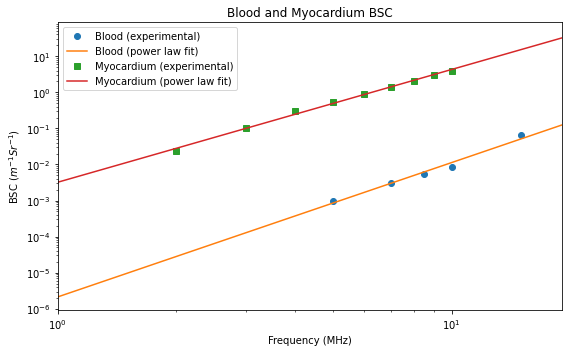

In [24]:
# get tabulated bsc values from power law fit
# an additional point at 25 MHz is appended to the data so that the resulting filters will have a sharp roll-off
blood_bsc = tissue.bsc_human_blood_powerfit(freqs=np.arange(0, 20.5e6, 1e6), append=[[25e6], [0]])
myo_bsc = tissue.bsc_canine_myocardium_powerfit(freqs=np.arange(0, 20.5e6, 1e6), append=[[25e6], [0]])

# plot original and power law fit data from 1 to 20 MHz
plt.figure(figsize=(8, 5))
x, y = tissue.bsc_human_blood()
plt.loglog(x / 1e6, y, 'o', label='Blood (experimental)')
plt.loglog(blood_bsc[0] / 1e6, blood_bsc[1], label='Blood (power law fit)')
x, y = tissue.bsc_canine_myocardium()
plt.loglog(x / 1e6, y, 's', label='Myocardium (experimental)')
plt.loglog(myo_bsc[0] / 1e6, myo_bsc[1], label='Myocardium (power law fit)')
plt.legend()
plt.xlabel('Frequency (MHz)')
plt.ylabel(r'BSC ($m^{-1} Sr^{-1}$)')
plt.xlim(1, 19)
plt.title('Blood and Myocardium BSC')
plt.tight_layout()
plt.show()

## FIR Filter Design

An FIR filter can be designed to simulate the effect of tissue backscatter and to ground the data from Field II to physical quantities. In addition to BSC, a physical model for the speckle produced by tissue will be required. We can use the simplest model of tissue composed of a large number of randomly positioned sub-wavelength scattering sites. The resulting speckle will have intensity which follows a Rayleigh distribution as a result of incoherent summation from the random phase, i.e. random walk in the complex plane [4]. The so-called fully-realized speckle will have some mean intensity which is tied to the BSC and this is the rationale behind the filter design.

The limitations of this model is that anistropy in the tissue (such as that from muscle fibers), interfaces, specular (e.g. bone), and other coherent or semi-coherent scattering phenomena won't be captured. Still, it is useful for soft tissue, cysts, and first-order estimates of backscattered intensity.

The specific normalization of the filter gains will also depend on the desired input and output variables from the simulation. In the simplest case (with the least amount of assumptions), the input is the normal surface acceleration of the transducer in transmit, and simulation output is the mean pressure at the surface of the transducer in receive. It is assumed that the presence of the transducer has no effect on the scattered field.
In this case, the gains are given by
$$g(f) = \frac{2 \pi}{area} \sqrt{\frac{\eta_{bs}(f)}{n_s}}$$
where $area$ is the surface area of the receive aperture and $n_s$ is the number density of the scatterers.

### Generate FIR filters based on BSC spectra

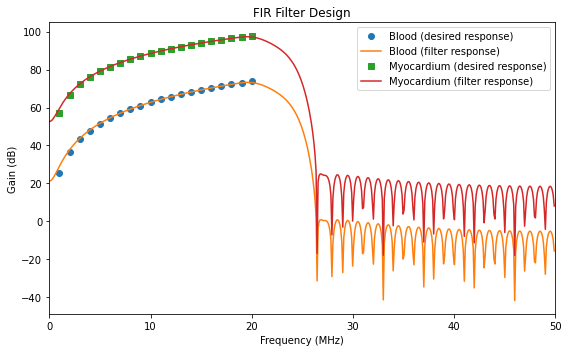

In [22]:
blood_fir = tissue.bsc_to_fir(*blood_bsc, area, ns, fs)
myo_fir = tissue.bsc_to_fir(*myo_bsc, area, ns, fs)

blood_w, blood_h = signal.freqz(blood_fir, fs=fs)
myo_w, myo_h = signal.freqz(myo_fir, fs=fs)

plt.figure(figsize=(8, 5))
y = 20 * np.log10(np.sqrt(blood_bsc[1][1:]) * 2 * np.pi / (area * np.sqrt(ns)))
plt.plot(blood_bsc[0][1:] / 1e6, y, 'o', label='Blood (desired response)')
plt.plot(blood_w  / 1e6, 20 * np.log10(np.abs(blood_h)), label='Blood (filter response)')
y = 20 * np.log10(np.sqrt(myo_bsc[1][1:]) * 2 * np.pi / (area * np.sqrt(ns)))
plt.plot(myo_bsc[0][1:] / 1e6, y, 's', label='Myocardium (desired response)')
plt.plot(myo_w  / 1e6, 20 * np.log10(np.abs(myo_h)), label='Myocardium (filter response)')
plt.legend()
plt.xlabel('Frequency (MHz)')
plt.ylabel('Gain (dB)')
plt.xlim(0, fs / 2 / 1e6)
plt.title('FIR Filter Design')
plt.tight_layout()
plt.show()

## Input/Output Variable Choice

We have chosen to use as the input the mean normal surface acceleration of the transmit aperture. For example, this could be generated from another linear model such as a piezoelectric or CMUT equivalent circuit where the input is the voltage excitation.

Likewise, the transduction from the output mean surface pressure in receive to voltage would require a similar receive model for the transducer and knowledge of the specific acoustic impedance that the transducer presents to the scattered field. The transduction models are beyond the scope of this example but could be included naturally in this theoretical framework.

### Generate the surface acceleration waveform

To create the input waveform, we simply scale a Gaussian pulse with the specified center frequency and bandwidth by a typical surface acceleration value for a CMUT.

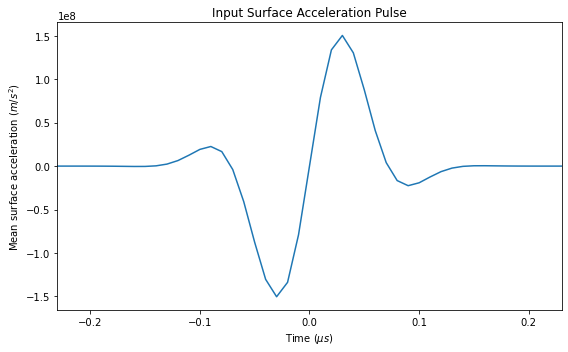

In [25]:
acc, acc_t = util.gausspulse(fc, bw / fc, fs, sym=False)
acc = acc * 190e6

plt.figure(figsize=(8, 5))
plt.plot(acc_t / 1e-6, acc)
plt.xlabel(r'Time ($\mu s$)')
plt.ylabel(r'Mean surface acceleration ($m / s^2$)')
plt.xlim(acc_t.min() / 1e-6, acc_t.max() / 1e-6)
plt.title('Input Surface Acceleration Pulse')
plt.tight_layout()
plt.show()

## Phantom Design

A phantom is created consisting of alternating layers of blood and myocardium. The phantom itself is made of a large number of scatterers randomly distributed in space. The scatterers are then assigned to a tissue type based on their location and the type designates which FIR filter is used in simulation.

Path-dependent attenuation is modeled to first-order by considering the intervening tissue layers along the path from the center of the aperture to the scatterer.

### Visualize the phantom and the path-dependent attenuation calculation

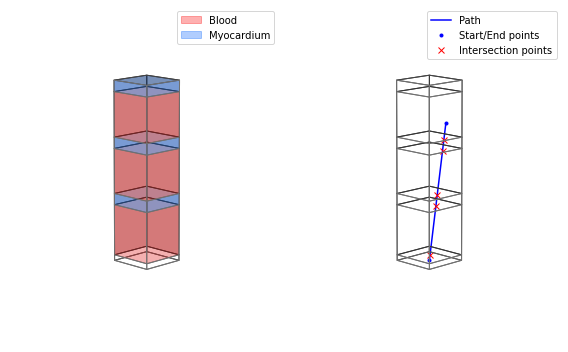

In [27]:
phantom = tissue.cardiac_penetration_phantom(dim, blood_att=blood_att, 
                                             myo_att=myo_att, ns=ns)

fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_axis_off()
ax1.azim = 45
ax1.elev = 10
cmap = {'none': '#ffffff00', 'blood': '#fc030350', 'myocardium': '#0362fc50'}
tissue.draw_phantom(phantom, colormap=cmap, ax=ax1)
util.set_axes_equal(ax1)
red = patches.Patch(color='#fc030350', label='Blood')
blue = patches.Patch(color='#0362fc50', label='Myocardium')
ax1.legend(handles=[red, blue])

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_axis_off()
ax2.azim = 45
ax2.elev = 10
tissue.draw_phantom(phantom, ax=ax2)
util.set_axes_equal(ax2)
tissue.draw_path_att((0, 0, 0), (0, 0.005, 0.025), phantom, ax=ax2)
ax2.legend()
plt.tight_layout()
plt.show()


## Simulate

Run Field II simulation for a typical single element CMUT aperture. The simulation may take some time depending on the phantom size and the scatterer density.

In [6]:
field = PyField()
field.field_init()

# set simulation parameters
field.set_field('c', c)
field.set_field('fs', fs)
field.set_field('att', 0)
field.set_field('freq_att', 0)
field.set_field('att_f0', fc)
field.set_field('use_att', 1)

# define aperture and set focus to infinity
th = field.xdc_2d_array(2, 2, 35e-6, 35e-6, 10e-6, 10e-6, np.ones((2, 2)), 1, 1, [0, 0, 300])

p_layers = []

# simulate each layer
for key, props in tqdm(phantom.items(), total=len(phantom.keys()), desc='Layer'):
    
    # skip `planes_x`, ... etc. keys
    if not isinstance(key, tuple):
        continue
    
    mat = props['material']
    scat = props['scat']
    
    # choose the FIR filter
    if mat.lower() == 'none':
        continue
    elif mat.lower() == 'blood':
        fir = blood_fir
    elif mat.lower() == 'myocardium':
        fir = myo_fir
    
    # simulate each scatterer
    p = np.zeros(1)
    for i, pt in tqdm(enumerate(scat), total=len(scat), leave=False, desc='Scatterer'):
        
        # calculate the spatial impulse response
        sir, sir_t0 = field.calc_h(th, pt)
        sir = np.pad(sir * fs, (int(round(sir_t0 * fs)), 0), 'constant')
        
        # calculate the attenuation
        att = tissue.calc_path_att([0, 0, 0], pt, phantom)
        
        # calculate the pressure
        p0 = rho * (att**2) * np.convolve(np.convolve(np.convolve(acc, sir) / fs, sir) / fs, fir) / fs 
        p, _ = util.sum_with_padding([p, p0], fs=fs)

    p_layers.append(p)

p_total, _ = util.sum_with_padding(p_layers, fs=fs)
field.field_end()

## Results

### Visualize the simulated aperture

The CMUT element is a 2 by 2 grid of 35 $\mu m$ membranes with 10 $\mu m$ kerf.

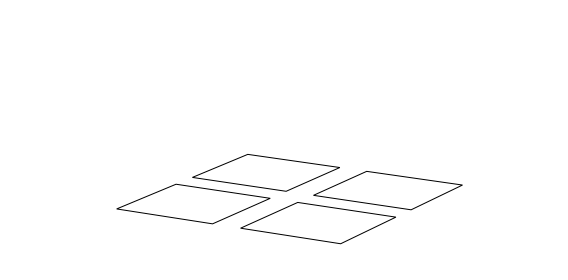

In [59]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection='3d')
ax.set_axis_off()
xdc_draw(rect, ax=ax)
plt.tight_layout()
plt.show()

### Plot backscattered pressure response

The pressure shows the echoes from the initial blood layer and subsequent echoes from myocardium layers in 1 cm intervals. This data could be compared with information on the minimum-detectable pressure (due to electronic/thermal noise etc.) to assess SNR, penetration depth and other metrics of interest.

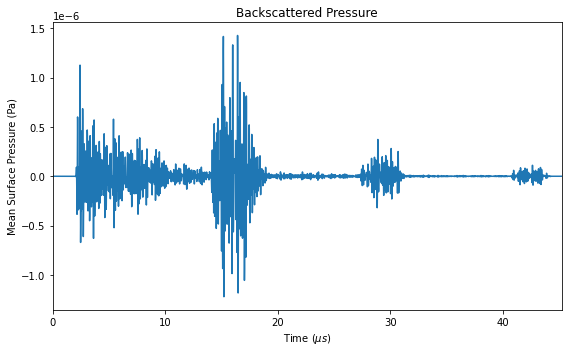

In [18]:
t = np.arange(len(p_total)) / fs

plt.figure(figsize=(8, 5))
plt.plot(t / 1e-6, p_total)
plt.xlabel(r'Time ($\mu s$)')
plt.ylabel('Mean Surface Pressure (Pa)')
plt.xlim(t.min() / 1e-6, t.max() / 1e-6)
plt.title('')
plt.tight_layout()
plt.show()

## References

[1] Shieh, Bernard, F. Levent Degertekin, and Karim Sabra. "Simulation of absolute backscattering coefficient in Field II." 2014 IEEE International Ultrasonics Symposium. IEEE, 2014.

[2] Shieh, Bernard D. Quantitative simulation of backscatter from tissue and blood flow for ultrasonic transducers. Diss. Georgia Institute of Technology, 2015.

[3] X. Chen, D. Phillips, K. Schwarz, J. Mottley, and K. Parker, “The measurement of backscatter
coefficient from a broadband pulse-echo system: a new formulation,” IEEE Transactions on
Ultrasonics, Ferroelectrics and Frequency Control, vol. 44, pp. 515–525, 1997.

[4] R. Wagner, S. Smith, J. Sandrik, and H. Lopez, “Statistics of speckle in ultrasound b-scans,”
IEEE Transactions on Sonics and Ultrasonics, vol. 30, pp. 156–163, 1983.